Hello everyone,

In this module, it is required to implement the feature extractor for Arabic Font Identification System.

At first, what are the main steps that we should go through in this module?


# TODOs:

1. Understand the problem
2. ..
3. Testing

# 1. Understand the problem

Calligraphers use some specific features, The main aim of this step is to transform these features into values that can be fed to a machine so it can decide on the style of a given text image. It should be mentioned that a feature might specify one or more styles. Features designated for each style or set of styles might be used in a sequential manner (sequential
decision) or parallel manner.



- Input: --
- Output: --

In [1]:
##################################################### imports #####################################################
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
# %run ../preprocessing/preprocessing.ipynb

# 2. Text thickness (Tth)
Stroke thickness plays an important role in defining the style. Some styles use a flat pen, whereas some others use a pointed one. In some styles, calligraphers alter the thickness while writing (via pushing down the pen or the opposite), whereas in others, the thickness is always preserved. Modeling such a feature in form of a descriptor will help the machine to understand more specificities of each style. Text thickness (Tth) descriptor codifies the appearance frequency of different line thicknesses in a text image. To extract this descriptor, we employ both the skeleton and edge image, and thickness is determined by the distance between skeleton and edges.

In [2]:
def Tth(skeleton_img, edge_img, bins=5):
    """Gets normalized histogram of text thickness 

    Args:
        skeleton_img: the image extracted skeleton
        edge_img: the image extracted edges
        
    Returns:
        hist : 1d array contains the normalized histogram values
        bin_edges : 1d array contains the bin edges values
    """

    skeleton = skeleton_img.copy()
    edge = edge_img.copy()

    # convert img to uint8 with 255:white 0:black

    if skeleton.max() == 1:
        skeleton = skeleton * 255
        skeleton = skeleton.astype(np.uint8)

    if edge.max() == 1:
        edge = edge * 255
        edge = edge.astype(np.uint8)

    # flipping edge => black text on white background
    edge = 255 - edge

    distance = cv2.distanceTransform(edge+skeleton, distanceType=cv2.DIST_L2, maskSize=5)
    # keeping only skeleton distances
    distance[skeleton==0] = 0
    
    h, h_bins = np.histogram(distance, range=(1, distance.max()), density=False, bins=bins)

    # normalizing the histogram
    h_sum = h.sum()
    if h_sum > 1:
        h = h/h_sum

    return h, h_bins

# 3. Special Diacritics (SDs)
Thuluth and Mohakik have a similar writing style that is decorated with diacritics having special shapes, as shown in Figure 9:
<img src="sds.png" alt="Figure 9" width="100"/>
An SDs descriptor will be used to inspect the existence of such diacritics in a given text image. To this end, HuMoments is calculated for the contours of the two diacritics in Figure 9.
Thereafter,  a score is calculated for a test image by calculating the distance between the two pre-calculated HuMoments and the test image diacritics contours HuMoments.


In [3]:

def precalculate_hu(path="sds.png", save=False, save_filename="sds_hue_moments"):
    """Utility function used by SDs to calculate hu moments for each contour, from one image contains diactritics
        
    Args:
        path: the path for the diactritics image
        save: if true, it will store the calculated values in sds_hue_moments
        save_filename: the filename in case of save=true, (default = sds_hue_moments)
    Returns:
        hu_moments: the calculated hu moments
    """

    # importing binarize from preprocessing module
    import sys
    sys.path.insert(1, "./../preprocessing/")
    from preprocessing import binarize

    sds_img = binarize(cv2.imread(path, 0))
    
    contours, _ = cv2.findContours(image=sds_img.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    hu_moments = []
    for contour in contours:
        moments = cv2.moments(contour)
        hu = cv2.HuMoments(moments)
        hu = np.array(hu).flatten()
        hu_moments.append(hu)

    hu_moments = np.array(hu_moments)
    
    if save:
        np.save(save_filename, hu_moments)

    return hu_moments

In [4]:
def SDs(img, recalculate=False, hu_file="sds_hue_moments.npy", path="sds.png"):
    """Gets an input image of the diacritics image and return a score determines how those diacritics are similar to mohakek and thuluth
        
    Args:
        diacritics_image: A binary image containing only diacritics (white text on black bg)
        recalculate: recalculate precalculate humoments values (default = False)
        path: path of image to recalculate humoments from (default = "sds.png")
        hu_file: file to read precalculated hu_moments from it or write to it in case of recalculate = True (default = "sds_hue_moments.npy")

    Returns:
        score: determine how those diacritics are similar to mohakek and thuluth (more similar => larger score)
    """
    
    # sd1 = np.array([2.40895486e-01, 4.84043539e-03, 1.38924440e-03, 3.48145819e-04, -6.47404757e-08, 6.90885170e-06, -2.33304273e-07])
    # sd2 = np.array([3.54057491e-01, 3.05011527e-03, 3.44288395e-02, 7.77674538e-04, 3.14350358e-06, 4.13909592e-05, -2.51216325e-06])


    if recalculate:
        sd = precalculate_hu(path, True, hu_file)
    else:
        sd = np.load(hu_file)

    contours, _ = cv2.findContours(image=img.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    hu_moments1 = []
    hu_moments2 = []
    
    for contour in contours:
        moments = cv2.moments(contour)
        hu = cv2.HuMoments(moments)
        hu = np.array(hu).flatten()
        d1 = np.linalg.norm(sd[0] - hu)
        d2 = np.linalg.norm(sd[1] - hu)
        hu_moments1.append(d1)
        hu_moments2.append(d2)
        # hu_moments.append(hu)

    # moments = cv2.moments(np.array(hu_moments))
    # hu = cv2.HuMoments(moments)

    # return hu.flatten()
    min_hu_moments = np.minimum(hu_moments1, hu_moments2)
    return (1/min_hu_moments).sum()

# 4. Words Orientation (WOr)
One of the salient features of the Diwani style is the words written in a slanted format. WOr descriptor mainly specifies how, on average, words in text are oriented. the orientation of each word contour (without diacritics) is calculated and then a mean oriatation is calculated weighted by the area of each word contour.
WOr algorithm was used to distinguish Diwani from other styles. Diwani style yieldan orientation average of about 45 degrees compared to 0 degrees by other styles.


In [5]:
def WOr(img, debug=False):
    """Gets an input image of the text without diacritics and return the mean orientation of words
        
    Args:
        text_only_image: A binary image containing only text wihtout diacritics (white text on black bg)
        debug: if true, show the bounding box of words (default False)
    Returns:
        orientation_mean: the weighted mean of words orientation
    """

    contours, _ = cv2.findContours(image=img.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    orientations = []
    areas = []

    if debug:
        rgb_img = cv2.cvtColor(img*255, cv2.COLOR_GRAY2RGB)

    for contour in contours:
        rect = cv2.minAreaRect(contour)
        _, dimensions, orientation = rect
        
        areas.append(dimensions[0]*dimensions[1])
        orientations.append(np.abs(orientation))
        

        if debug:
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(rgb_img,[box],0,(255,255,255),1)
    

    if debug:
        plt.imshow(rgb_img)

    weighted_mean = np.dot(areas, orientations) / np.sum(areas)

    return weighted_mean
    


# 3. Testing

In [6]:
def testing():
    # import randrange
    from random import randrange
    # importing io module
    import sys
    sys.path.insert(1, "./../io_utils/")
    from io_utils import read_data, read_classes

    # importing preprocessing module
    sys.path.insert(1, "./../preprocessing/")
    from preprocessing import binarize, extract_edges, extract_skeleton, separate_diacritics_and_text

    # reading data and class names
    classes_names = read_classes('../ACdata_base/names.txt')
    dataset_images, dataset_labels = read_data('../ACdata_base/')
    
    assert len(dataset_images) == len(dataset_labels)

    # get the range of each class in the dataset
    ranges = [0]
    tmp = dataset_labels[0]
    for idx, num in enumerate(dataset_labels):
        if num != tmp:
            tmp = num
            ranges.append(idx)
    ranges.append(len(dataset_labels))

    # Choosing a random example from each class and apply the preprocessing Functions on it
    for i, class_name in enumerate(classes_names):
                    
        index = randrange(ranges[i], ranges[i+1])
        test_image = dataset_images[index]
        binary_image = binarize(test_image)
        skeleton_image = extract_skeleton(test_image)
        edge_image = extract_edges(test_image)
        diacritics_image, text_image = separate_diacritics_and_text(test_image)

        assert len(np.unique(np.asarray(binary_image))) == 2

        tth, _ = Tth(skeleton_image, edge_image)
        sds = SDs(diacritics_image)
        wor = WOr(text_image)

        f, axarr = plt.subplots(1,1, figsize=(10, 7))
        f.suptitle("Tth: " + np.array2string(tth) + "\nSDs: " + str(sds) + "\nWOr: " + str(wor))

        axarr.imshow(test_image, cmap='gray')
        axarr.set_title(class_name)




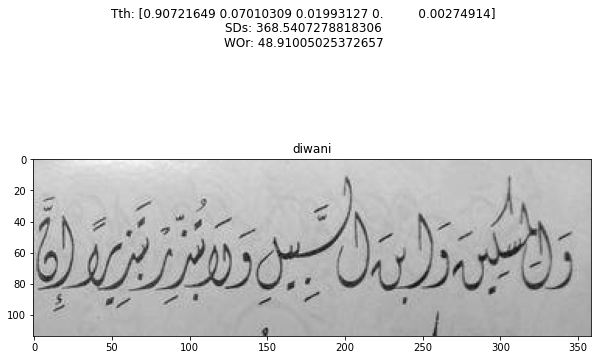

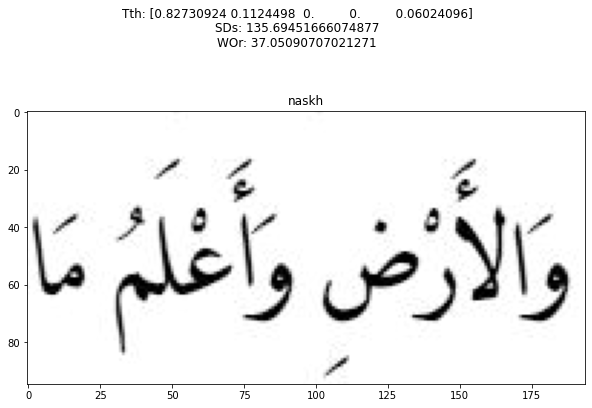

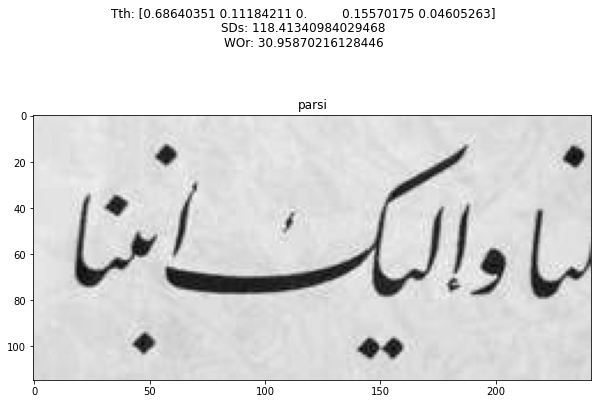

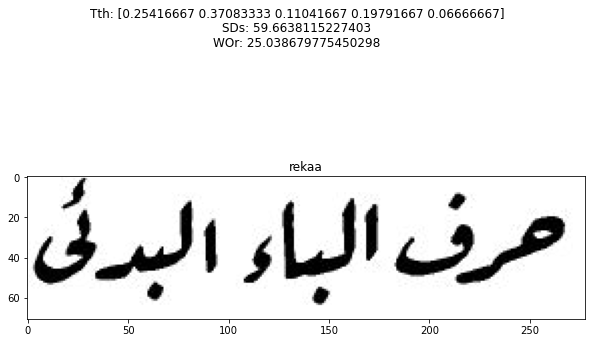

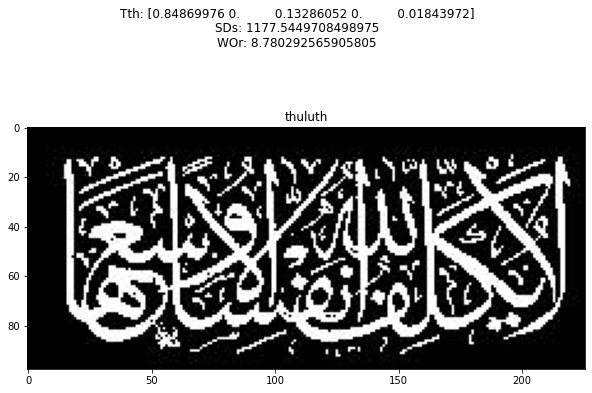

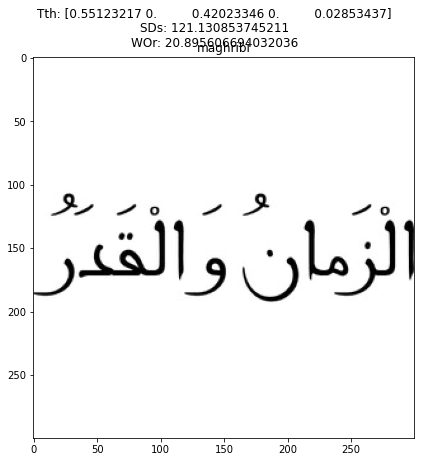

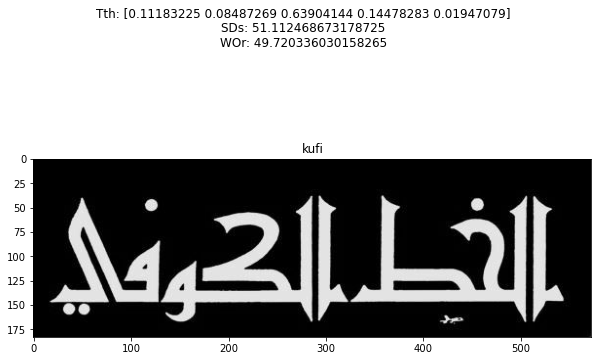

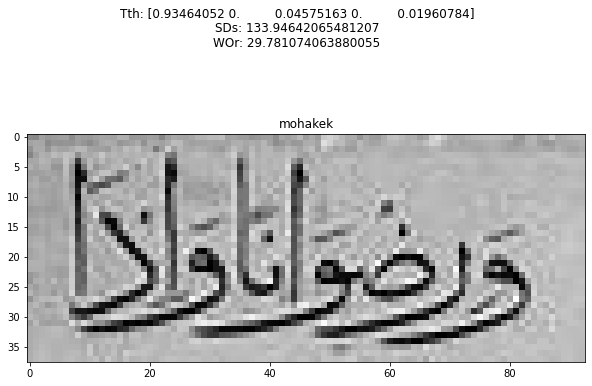

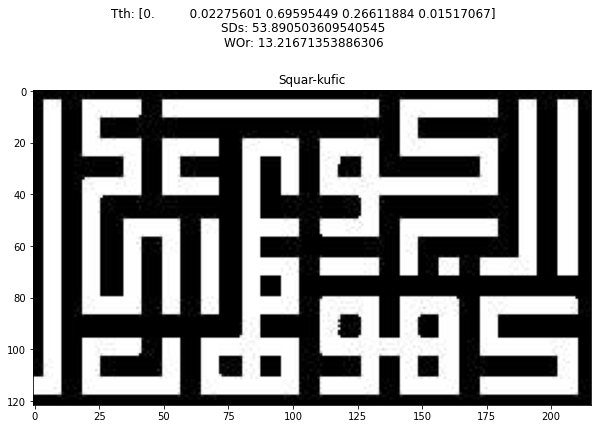

In [7]:
if __name__ == '__main__':
    testing()

In [8]:
def create_py():
    !jupyter nbconvert --to script feature_extraction.ipynb

In [9]:
if __name__ == '__main__':
    create_py()

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook feature_extraction.ipynb to script
[NbConvertApp] Writing 10127 bytes to feature_extraction.py
